<a href="https://colab.research.google.com/github/KatBCN/ML-PropertyAssessment/blob/main/ML_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Kat Comment: June 4, I read through this notebook to try to understand everything and also experimented with some changes to simplify our data for the modeling. I added comments throughout the notebook for things I didn't understand or think we should discuss.

* I saved prior versions of your work including this notebook and the datasets this notebook created in GitHub, so we can always revert back to an earlier version if needed.

# Data Preprocessing

Data preprocessing pipeline

## Setting up the environment

In [1]:
# import libraries
from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import math
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor

# set options
pd.set_option('display.max_columns', None) 

# mount drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ML/ML-Project/
%ls 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ML/ML-Project
 code/
 data/
 Kat-ML-Preprocessing-PropertyAssessment-Buffalo.ipynb
 ML-BuffaloPropertyAssessment.gdoc
 ML-DataSplit-PropertyAssessment-Buffalo.ipynb
 ML-FinalReport-BuffaloPropertyAssessment.gdoc
 ML-Modeling-LinearRegression-PropertyAssessment-Buffalo.ipynb
 ML-Modeling-PropertyAssessment-Buffalo.ipynb
 ML-Preprocessing-PropertyAssessment-Buffalo.ipynb
 ML-PropertyAssessment-Buffalo.ipynb
 ML-PropertyAssessment-Strathcona.ipynb
 ML-Questions.gdoc
 models/
'Reference Articles'/


## Pipeline functions

### Read data split

In [2]:
def read_data_split(filepath):
  
  df = pd.read_pickle(filepath)

  return df
  

### Remove empty columns

Some of the columns in our data are completely or nearly empty. We will get rid of them since we couldn't possibly do good imputation.

We set our threshold at 90%

In [3]:
def remove_empty_columns(df, threshold = 0.9):
  nas_per_column = df.isna().sum().sort_values()
  empty_columns = nas_per_column[nas_per_column / df.shape[0]*100 > 90].index.to_list()
  df = df.drop(empty_columns, axis=1)
  
  print("The removed columns with more than 90% missing values are: " + ', '.join(sorted(empty_columns)))

  return df

### Remove redundant columns

Some of our columns contain values that are redundant or contained by other columns. We will remove those.

In [4]:
def remove_redundant_columns(df):
  redundant_columns = ["Property Class", "City", "State", "Location"]
  df = df.drop(redundant_columns, axis=1)

  print("The removed redundant columns are: " + ', '.join(sorted(redundant_columns)))
  
  return df

### Define datatypes

When reading the original files into pandas, we made sure that no datatype inference was being done to avoid unwanted modifications of our data. This function will help us define the correct datatypes.

In [5]:
def define_datatypes(df):
  datatypes_dict = {"category": ["Property Class Description", "Year Built", 
                               "Overall Condition", "Building Style",
                                "Tax District", "Zipcode", "Council District", 
                               "Police District", "Census Tract", 
                               "Census Block Group", "Census Block",
                               "Neighborhood", "Roll",
                               "Overall Condition", "Building Style", 
                               "Heat Type","Basement Type"],
                  "date":   ["Deed Date"],
                  "int":    ["# of Beds", "# of Baths", "# of Fireplaces",
                             "Deed Book", "Deed Page", "Year Built"],
                  "float":  ["Front", "Depth","Sale Price","Land Value", 
                             "Total Value","Total Living Area", "Longitude",
                             "Latitude"],
                  "str": ["Print Key"]
                  }

  for key in datatypes_dict.keys():
    if key == "date":
      for column in datatypes_dict[key]:
        df[column] = pd.to_datetime(df[column])
    elif key == "int":
      for column in datatypes_dict[key]:
        df[column] = pd.to_numeric(df[column], errors="coerce") 
    else:  
      for column in datatypes_dict[key]:
        df[column] = df[column].astype(key)

  return df

### Decode Property Class

- Kat comment: I don't understand what this function is doing. What is its purpose? 
- Kat comment: Some strange results: "INNS,LODGES,BOARDING AND ROOMING HOUSES" is showing up as previous property class for "ONE FAMILY DWELLING" and "ONE FAMILY DWELLING" is showing up as previous property class for "TWO FAMILY DWELLING"

In [6]:
def decode_property_classes(df):
  pairs = df[["Property Class", "Property Class Description"]].drop_duplicates()
  
  classes_dict = {}
  for i, row in pairs.iterrows():
    classes_dict[row["Property Class"]] = row["Property Class Description"]

  df["Previous Property Class"] = df["Previous Property Class"].map(classes_dict)
  
  return df




### Decode NAs

Some missing values have been encoded using encoded values of the datatype domain instead of null values. We want to decode those.

In [7]:
def decode_encoded_NAs(df):
  df['Deed Date'] = df['Deed Date'].replace("09/09/9999", pd.NaT)

  return df

### Filter out properties that are not one or two family dwellings.

Among our >90k registered properties, some have no buildings on them, meaning that they're vacant land. We will filter those since these rows are structurally different (are missing many fields) and to reduce the complexity of our dataset before getting to modeling. 

During data exploration, we also discovered that the majority of properties are One or Two Family dwellings, and each category has an approximately normal distribution of Total Living Area. Our models are limited to these two property types.

In [19]:
def filter_by_property_class(df):
  # keeping track of how many rows are removed by filter
  original_row_count = df.shape[0]

  df = df[df["Property Class Description"].isin(["ONE FAMILY DWELLING", "TWO FAMILY DWELLING"])]
  # remove unused category labels after perfomring the filter operation.
  df['Property Class Description'].cat.remove_unused_categories(inplace=True)
  
  new_row_count = df.shape[0]
  print("The number of rows removed by filtering property class:", (original_row_count - new_row_count), "Ratio retained:", (new_row_count/original_row_count))  

  return df

### Feature engineering

We found some patterns in our textual variables that can be converted into new fields that are more adequate for modelling.

In [9]:
def some_feature_engineering(df):
  ### Do owners 1 and 2 have the same surname?
  # Extract surnames
  df["Surname1"] = df["Owner1"].str.split()
  df["Surname1"] = [i[0] if i[0] is not None else None for i in df["Surname1"] ] 
  df["Surname2"] = df["Owner2"].str.split()
  df["Surname2"] = [i[0] if type(i) == list else None for i in df["Surname2"] ] 

  # Create new column for co-owners with the same surname
  df["SameOwnerFirstName"] = 0
  df.loc[df["Surname2"] == df["Surname2"], "SameOwnerFirstName"] = 1


  ### Is the owner a corporation, related to Buffalo's administration, or neither of those?
  # Check for owners containing corporation names, or containing Buffalo 
  df["Owner1_inc"] = [2 if i == True else 0 for i in df["Owner1"].str.contains("LLC|DIST|CORP|INC|GROUP|STATE|PROPERT|MANAGEMENT") ] #INC, BUFFALO, CORP, GROUP, MANAGEMENT have samples big enough and modify the price by a lot
  df["Owner1_buff"] = [1 if i == True else 0 for i in df["Owner1"].str.contains("BUFFALO")]

  # Create new column with the combination of both corporations + buffalo 
  df["OwnershipType"] = df["Owner1_inc"] - df["Owner1_buff"] 

  # Put together codes 1 and 2 (similar average target value) and decode
  df["OwnershipType"] = [i if i != 2 else 1 for i in df["OwnershipType"]]
  OwnershipType_dict = {1: "Corporation", -1: "Buffalo", 0: "Person"}
  df["OwnershipType"] = df["OwnershipType"].replace(OwnershipType_dict)

  ### Remove deprecated and temporal columns
  removable_columns = ["Owner1","Owner2", "Surname1", "Surname2",
                     "Owner1_inc","Owner1_buff"]
  df = df.drop(removable_columns, axis=1)

  return df

### Decode bathroom coding
The number of bathrooms in a house is usually expressed in terms of full bathrooms and half bathrooms in the U.S.A.

When a house has 2 full bathrooms and a half bathroom (no shower/bathtub), it can be expressed as 2.5 bathrooms.

An evolution of this coding led to encoding the number of full bathrooms as the full part of the float, and the number of half bathrooms as the decimal part of the float. This way, a house with two full and two half bathrooms will be a 2.2 bathroom house. 

Both encodings coexist in our dataset. Some houses houses with 2 full and 1 half bath are expressed as 2.5 and some as 2.1. 

We will take care of variable by adding up the total number of full and half bathrooms. 

- Kat comment: I don't understand this part. Are 2.2 bathrooms rounded up to 4? I recommend keeping the # of Baths column so that we can compare performance of the original column and our engineered column to make sure this method is actually an improvement.

In [10]:
def decode_bathrooms(df):
  # decode the float values of "# of Baths"
  totl_bath_list = []
  for i in df['# of Baths'].astype("str").str.split("."):
    full_baths = int(i[0])
    if int(i[1]) != 5:  #assuming that 5 half bathrooms is highly improbable
      half_baths = int(i[1])
    else:
      half_baths = 1
    totl_bath_list.append(full_baths + half_baths)
  df["TotalBaths"] = totl_bath_list

  # Remove deprecated column
  # df = df.drop("# of Baths", axis=1)

  return df

### Remove unwanted columns

After some preliminary data exploration, many of our variables contain data with too many levels or completely unrelated to our target variable. We will remove these. We are also removing Land Value, a secondary target variable that we will not be looking into. It can't be used to predict because both Land Value and Total Value are assesed at the same time. 

In [11]:
def remove_unwanted_columns(df):
  unwanted_columns = ["Print Key", "Mail3", "Mail4", "House Number", "Street", 
                      "Deed Book", "Deed Page", "Deed Date", "Land Value"]
  df = df.drop(unwanted_columns, axis=1)
  print("The removed unwanted columns are: " + ', '.join(sorted(unwanted_columns)))
  
  return df

### Remove alternate location features
There are too many categorical variables that represent the location of the property. During one-hot encoding, these will explode the feature space. We will only keep the feature 'neighborhood'

This could be combined with the function to remove redundant columns.

In [12]:
def remove_location_features(df):
  unwanted_location = ["Tax District", "Zipcode", "Roll", "Council District",
                       "Police District", "Census Tract", "Census Block Group",
                       "Census Block"]
  df = df.drop(unwanted_location, axis=1)
  print("The removed location features are: " + ', '.join(sorted(unwanted_location)))
  
  return df

### Define the pipeline

In [13]:
def run_preprocessing_pipeline(filepath):
  df = read_data_split(filepath)
  df = remove_empty_columns(df)
  # df = decode_property_classes(df) # I commented out this function because I do not understand its purpose.
  df = remove_redundant_columns(df)
  df = decode_encoded_NAs(df)
  df = define_datatypes(df)
  df = filter_by_property_class(df)
  df = some_feature_engineering(df)
  df = decode_bathrooms(df)
  df = remove_unwanted_columns(df)
  df = remove_location_features(df)

  return df


## Run preprocessing

This runs the pre-processing pipeline on the initial splits of training and validation data and saves the data files in the preprocessed folder.

* Kat comment: Is there a reason for not running the preprocessing on the test partition?

In [20]:
for i in ["train","validation"]:
  print ("Processing: ", i)
  path = "data/initial_splits/" + i + "_BuffaloProperty.pkl"
  df = run_preprocessing_pipeline(path)
  df.to_pickle("data/preprocessed/" + i + "_BuffaloProperty.pkl")

Processing:  train
The removed columns with more than 90% missing values are: # of Kitchens, # of Stories, Address, First Story Area, Mail1, Mail2, Previous Owner, Second Story Area, Zipcode Extension
The removed redundant columns are: City, Location, Property Class, State


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


The number of rows removed by filtering property class: 16606 Ratio retained: 0.6854745534784173
The removed unwanted columns are: Deed Book, Deed Date, Deed Page, House Number, Land Value, Mail3, Mail4, Print Key, Street
The removed location features are: Census Block, Census Block Group, Census Tract, Council District, Police District, Roll, Tax District, Zipcode
Processing:  validation
The removed columns with more than 90% missing values are: # of Kitchens, # of Stories, Address, First Story Area, Mail1, Mail2, Previous Owner, Second Story Area, Zipcode Extension
The removed redundant columns are: City, Location, Property Class, State
The number of rows removed by filtering property class: 5485 Ratio retained: 0.68833456446389
The removed unwanted columns are: Deed Book, Deed Date, Deed Page, House Number, Land Value, Mail3, Mail4, Print Key, Street
The removed location features are: Census Block, Census Block Group, Census Tract, Council District, Police District, Roll, Tax Distri

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Outlier detection and removal

It seems like we have several numeric columns with some encoded NAs. Sale Price, Front, Depth, and other columns have 0s that may have been introduced as a placeholder for a missing value. 

In [ ]:
### Decode Sale Price hidden NAs
def declare_encoded_NAs(df, min_sale_price_admitted = 100):
  # Sale price sometimes is below 100 it shouldn't represent a real value, 
  # its only simbolic. Often done to "donate" properties to family members. 
  # Sale prices of 0 might simply represent no sale. 

  df["Sale Type"] = np.NaN
  df.loc[ df["Sale Price"] <= min_sale_price_admitted , ["Sale Type"]] = "No Sale"
  df.loc[ df["Sale Type"] != "No Sale" , ["Sale Type"]] = "Real Sale"
  df.loc[ df["Sale Type"] == "No Sale", ["Sale Price"]] = np.NaN  # aprox. 40% NAs

  # Front, Depth or Living area
  df.loc[ df["Front"] == 0, ["Front"]] = np.NaN # less than 100 NAs
  df.loc[ df["Depth"] == 0, ["Depth"]] = np.NaN # approx 800 NAs

  remove_rows = df.loc[ df["Total Living Area"] == 0].index # 17 rows, all missing information about the building
  remove_rows.append(df.loc[ df["Total Living Area"] == 1].index) # 1 row
  
  df = df.drop(remove_rows) # remove the rows missing too much information

  return df



In [ ]:
def get_numerical_columns(df):
  num = df.select_dtypes(include=np.number)  # Get numeric columns
  num.drop(["Latitude", "Longitude", "SameOwnerFirstName"], axis=1, inplace=True)
  
  return num


def compute_outlier_df(df):
  num = get_numerical_columns(df)

  outlier_df = pd.DataFrame(columns=["total_outliers","small_outliers","big_outliers", "lower_bound", "higher_bound"])
  for col in num:
    Q1 = num[col].quantile(0.25)
    Q3 = num[col].quantile(0.75)
    IQR = Q3 - Q1
    Q1, Q3, IQR

    small_outliers = (num[col] < (Q1 - 3 * IQR))
    big_outliers = (num[col] > (Q3 + 3 * IQR))
    total_outliers = small_outliers.sum() + big_outliers.sum()

    outlier_df.loc[col, "big_outliers"] = big_outliers.sum()
    outlier_df.loc[col, "small_outliers"] = small_outliers.sum()
    outlier_df.loc[col, "total_outliers"] = total_outliers
    outlier_df.loc[col, "lower_bound"] = Q1 - 3 * IQR
    outlier_df.loc[col, "higher_bound"] = Q3 + 3 * IQR
    
  return outlier_df


def draw_hists(df):
  num = get_numerical_columns(df)
  outlier_df = compute_outlier_df(df)
  n = num.shape[1]  # Number of cols
  fig, axes = plt.subplots(n, 1, figsize=(14, 24))  # create subplots

  for ax, col in zip(axes, num):  
      p = sns.distplot(num[col], ax=ax)   # Plot histogram
      ax.axvline(num[col].mean(), c='k')  # Plot mean
      ax.axvline(outlier_df["lower_bound"][col], c="r")
      ax.axvline(outlier_df["higher_bound"][col], c="r")

  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


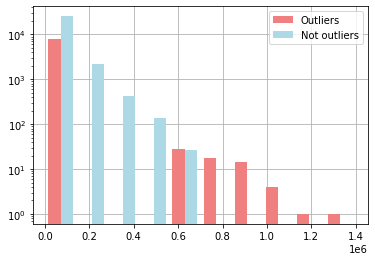

In [ ]:
#
#local_outlier_factor = LocalOutlierFactor(n_neighbors=200)
#result = local_outlier_factor.fit_predict(df['Total Value'].values.reshape(-1, 1))
#
#outliers = result == -1 
#no_outliers = result == 1
#
#plt.rc('axes', axisbelow=True)
#plt.hist([df.loc[outliers, "Total Value"], df.loc[no_outliers, "Total Value"]], color=['lightcoral','lightblue'], log=True)
#plt.grid()
#plt.legend(["Outliers", "Not outliers"])
#plt.show()
#
#

*   Kat comment: - How was 400000 chosen as the cutoff? 


In [ ]:
def remove_target_outliers(df):
  # remove rows that are extreme outliers for our target 
  rows_to_remove = df[df["Total Value"] > 400000].index
  df = df.drop(rows_to_remove)
  print("Removed", len(rows_to_remove), "rows")
  return df



*   Kat comment - df1 is not defined, this code cannot be run.



In [ ]:
compute_outlier_df(df1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,total_outliers,small_outliers,big_outliers,lower_bound,higher_bound
Front,727,0,727,0.0,70.0
Depth,255,15,240,27.0,209.0
Total Value,1066,0,1066,-94000.0,200000.0
Sale Price,715,0,715,-159000.0,268000.0
Year Built,131,47,84,1819.0,2008.0
Total Living Area,21,0,21,-1432.0,5001.0
# of Fireplaces,4258,0,4258,0.0,0.0
# of Beds,2,0,2,-3.0,11.0
TotalBaths,5,0,5,-2.0,5.0


In [ ]:
#draw_hists(df1)


* Kat comment: Is column_tuples supposed to be a list of tuples?
* Kat comment: This function is removing the whole row if one of the columns is identified as an outlier - is that correct?

In [ ]:
def remove_predictor_outliers(df, column_tuples):
  """
  remove outliers for the variables specified in column tuples
  the tuples should be specified as ("column_name", limits)
  limit can be default (function takes the limits from 3xIQR)
  or they can be splicit
  """
  new_df = df.copy()

  outlier_df = compute_outlier_df(df)


  for tpl in column_tuples:
    col = tpl[0]
    limits = tpl[1]
    if limits == "default":
      limits = (outlier_df.lower_bound[col], outlier_df.higher_bound[col])

    new_df.loc[ (new_df[col] < limits[0]) | (new_df[col] > limits[1]) , col] = np.NaN
  
  return new_df



In [ ]:
#draw_hists(df2)



In [ ]:


#categorical_columns = df2.columns[df2.dtypes == "category"]
#object_columns = df2.columns[df2.dtypes == "object"]
#
#ohe_columns = [*categorical_columns, *object_columns]
#
#for col in categorical_columns:
#  df2[col].cat.remove_unused_categories(inplace=True)
#
#ohe_df = pd.DataFrame()
#for col in ohe_columns:
#  ohe_df[col], uniques = pd.factorize(df2[col])
#  ohe_df.loc[ohe_df[col] == -1] = np.NaN
#
#ohe_df
#ohe_df["Heat Type"].isna().sum()
#df2["Heat Type"].isna().sum()

- Kat comment: I don't think we should hard code the name of the variables in the def get_catgorical_columns. Remove the commented code if you agree.
- Kat comment: We could also consider defining the object type columns as category type earlier in the pipeline.



In [ ]:
import sklearn.preprocessing as preprocessing

def get_categorical_columns(df):
  object_columns = df.select_dtypes(include='object').columns.tolist()
  # convert object type columns to category type
  for col in object_columns:
    df[col] = df[col].astype("category")
  
  categorical_columns = df.select_dtypes(include='category').columns.tolist()

  """
  # commenting out this code so that we don't need to hard code the column names.
  categorical_columns = ['Tax District', 'Property Class Description', 'Zipcode', 'Roll',
       'Overall Condition', 'Building Style', 'Heat Type', 'Basement Type',
       'Council District', 'Police District', 'Census Tract',
       'Census Block Group', 'Census Block', 'Neighborhood']
  object_columns = ['Previous Property Class', 'OwnershipType', 'Sale Type']
  """
  # we could update this to only return the categorical columns since we convert objects to categories
  return categorical_columns, object_columns


- Kat comment: I don't think the label encoder is the correct function to use in this case. According to the documentation, it is only meant to be used on the target variable, not on training variables.
[Label Encoder Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
- Kat comment: In this article, [Label Encoding vs One-Hot Encoding](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd), it explains that algorithms often misinterpret the numbers of label encoding. The imputer calculates neighbors, and is probably misusing the labels as though they have a numerical meaning.

In [ ]:

def encode_categories(df):
  # use LabelEncoder to encode our categorical variables to dummy numbers
  categorical_columns, object_columns = get_categorical_columns(df)
  columns_to_encode = [*categorical_columns, *object_columns]

  for col in categorical_columns:
    df[col].cat.remove_unused_categories(inplace=True)

  new_df = df.copy()
  mask = new_df.isnull()

  encoders={}
  for col in columns_to_encode:
    encoders[col] = preprocessing.LabelEncoder()
    encoders[col].fit(df[col].unique())
    new_df[col] = encoders[col].transform(new_df[col])

  new_df = new_df.where(~mask, np.NaN)

  return new_df, encoders


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [ ]:
def fit_category_decoder(original_df, encoded_df):
  categorical_columns, object_columns = get_categorical_columns(df)
  columns_to_decode = [*categorical_columns, *object_columns]

  label_dict = {}
  for col in columns_to_decode:
    label_dict[col] = {}
    prev_values = original_df[col].unique()
    new_values = encoded_df[col].unique()

    for new_value, prev_value in zip(new_values, prev_values):
      label_dict[col][new_value] = prev_value
  
  return label_dict


def decode_categories(df, decoder):
  new_df = df.copy()

  label_dict = decoder

  categorical_columns, object_columns = get_categorical_columns(df)
  columns_to_decode = [*categorical_columns, *object_columns]


  for column in columns_to_decode:
    new_df[column] = new_df[column].map(label_dict[column])

  return new_df
  

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from joblib import dump, load



def train_imputer(training_df, imputer_path='models/imputer2.joblib'):
  df = training_df.drop("Total Value", axis=1)
  complete_df = df.dropna()

  imp = IterativeImputer(max_iter=10, random_state=0)
  imp.fit(complete_df)

  dump(imp, imputer_path) 


def impute_missing_values(df, imputer_path='models/imputer2.joblib'):
  df_no_target = df.drop("Total Value", axis=1)
  complete_df = df_no_target.dropna()
  missing_rows = df_no_target.isnull().any(axis=1)

  imp = load(imputer_path)

  new_df = pd.DataFrame(imp.transform(df_no_target), 
                     columns = df_no_target.columns, index=df_no_target.index)

  new_df["Total Value"] = df["Total Value"]

  return new_df






Testing imputation with different encoding method and fewer columns.

In [ ]:
### Kat Test with different encoding method
train_df = pd.read_pickle("data/preprocessed/train_BuffaloProperty.pkl")

train_df = declare_encoded_NAs(train_df)
compute_outlier_df(train_df)
#draw_hists(df)

# this function removes rows
df1 = remove_target_outliers(train_df)

outlier_tuples = [
          ("Front", "default"),
          ("Depth", "default"),
          ("Sale Price", (0, 400000)),
          ("Total Living Area", "default"),
          ("Front", "default") ]

# this function does not remove rows.
df2 = remove_predictor_outliers(df1, outlier_tuples)


Removed 253 rows


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df3 = pd.get_dummies(df2)
df3.shape

(35921, 99)

34 seconds to train the imputer.

In [ ]:
train_imputer(df3)

In [ ]:
df4 = impute_missing_values(df3)

In [ ]:
df4.shape

(35921, 99)

In [ ]:
df4.head(10)

,Front,Depth,Sale Price,Year Built,Total Living Area,# of Fireplaces,# of Beds,# of Baths,Latitude,Longitude,SameOwnerFirstName,TotalBaths,Property Class Description_ONE FAMILY DWELLING,Property Class Description_TWO FAMILY DWELLING,Previous Property Class_210,Previous Property Class_215,Previous Property Class_220,Previous Property Class_230,Previous Property Class_281,Previous Property Class_311,Previous Property Class_411,Previous Property Class_418,Previous Property Class_425,Previous Property Class_465,Previous Property Class_483,Previous Property Class_484,Overall Condition_1,Overall Condition_2,Overall Condition_3,Overall Condition_4,Overall Condition_5,Building Style_01,Building Style_02,Building Style_03,Building Style_04,Building Style_05,Building Style_06,Building Style_07,Building Style_08,Building Style_09,Building Style_1,Building Style_10,Building Style_12,Building Style_13,Building Style_14,Building Style_15,Building Style_17,Building Style_5,Building Style_8,Heat Type_1,Heat Type_2,Heat Type_3,Heat Type_4,Basement Type_1,Basement Type_2,Basement Type_3,Basement Type_4,Neighborhood_Allentown,Neighborhood_Black Rock,Neighborhood_Broadway Fillmore,Neighborhood_Central,Neighborhood_Central Park,Neighborhood_Delavan Grider,Neighborhood_Ellicott,Neighborhood_Elmwood Bidwell,Neighborhood_Elmwood Bryant,Neighborhood_Fillmore-Leroy,Neighborhood_First Ward,Neighborhood_Fruit Belt,Neighborhood_Genesee-Moselle,Neighborhood_Grant-Amherst,Neighborhood_Hamlin Park,Neighborhood_Hopkins-Tifft,Neighborhood_Kaisertown,Neighborhood_Kenfield,Neighborhood_Kensington-Bailey,Neighborhood_Lovejoy,Neighborhood_Lower West Side,Neighborhood_MLK Park,Neighborhood_Masten Park,Neighborhood_North Park,Neighborhood_Parkside,Neighborhood_Pratt-Willert,Neighborhood_Riverside,Neighborhood_Schiller Park,Neighborhood_Seneca Babcock,Neighborhood_Seneca-Cazenovia,Neighborhood_South Park,Neighborhood_UNKNOWN,Neighborhood_University Heights,Neighborhood_Upper West Side,Neighborhood_West Hertel,Neighborhood_West Side,OwnershipType_Buffalo,OwnershipType_Corporation,OwnershipType_Person,Sale Type_No Sale,Sale Type_Real Sale,Total Value
SBL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1003800004027000,25.000000,130.00,147813.577677,1908.0,1972.0,1.0,3.0,1.0,42.911948,-78.873319,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,175000.0
0907200002032000,30.000000,120.00,2000.000000,1920.0,2168.0,0.0,6.0,2.0,42.925223,-78.814022,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,10000.0
0896700003003000,35.000000,107.00,39797.578948,1900.0,2424.0,0.0,6.0,2.0,42.926596,-78.845734,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,33800.0
0797100006030000,70.000000,115.00,39500.000000,1940.0,1796.0,0.0,4.0,1.1,42.945210,-78.823728,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

* Kat comment: I don't fully understand what outlier_tuples is doing. 
* Kat comment: Why is sale price set between 0 and 400000?

In [ ]:
####TESTING

train_df = pd.read_pickle("data/preprocessed/train_BuffaloProperty.pkl")



train_df = declare_encoded_NAs(train_df)
compute_outlier_df(train_df)
#draw_hists(df)

df1 = remove_target_outliers(train_df)


outlier_tuples = [
          ("Front", "default"),
          ("Depth", "default"),
          ("Sale Price", (0, 400000)),
          ("Total Living Area", "default"),
          ("Front", "default") ]

df2 = remove_predictor_outliers(df1, outlier_tuples)

df3, encoders3 = encode_categories(df2)
decoder = fit_category_decoder(df2, df3)

with open('data/imputed/category_decoder_dict.pkl', 'wb') as handle:
    pickle.dump(decoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_imputer(df3)

df4 = impute_missing_values(df3)



df4.to_pickle("data/imputed/train_BuffaloProperty.pkl")

df5 = decode_categories(df4, decoder)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Removed 253 rows


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


False


In [ ]:
val_df = pd.read_pickle("data/preprocessed/validation_BuffaloProperty.pkl")



val_df = declare_encoded_NAs(val_df)
compute_outlier_df(val_df)
#draw_hists(df)

vdf1 = remove_target_outliers(val_df)


outlier_tuples = [
          ("Front", "default"),
          ("Depth", "default"),
          ("Sale Price", (0, 400000)),
          ("Total Living Area", "default"),
          ("Front", "default") ]

vdf2 = remove_predictor_outliers(vdf1, outlier_tuples)

vdf3, vencoders3 = encode_categories(vdf2)
vdecoder = fit_category_decoder(vdf2, vdf3)


vdf4 = impute_missing_values(vdf3)

vdf4.to_pickle("data/imputed/validation_BuffaloProperty.pkl")


vdf5 = decode_categories(vdf4, decoder)

vdf5



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Removed 88 rows


,Tax District,Front,Depth,Property Class Description,Previous Property Class,Zipcode,Roll,Sale Price,Year Built,Total Living Area,Overall Condition,Building Style,Heat Type,Basement Type,# of Fireplaces,# of Beds,Council District,Police District,Census Tract,Census Block Group,Census Block,Neighborhood,Latitude,Longitude,SameOwnerFirstName,OwnershipType,TotalBaths,Sale Type,Total Value
SBL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1334600001006000,147013,50.0,155.000000,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14218,1,64270.284399,1955.0,1066.0,3,01,2,4,0.0,3.0,SOUTH,District A,19,3,2032,Hopkins-Tifft,42.845672,-78.831177,1.0,Person,1.0,No Sale,65000.0
1007600006028000,147004,30.0,127.000000,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14210,1,3000.000000,1817.0,1498.0,2,08,2,3,0.0,2.0,FILLMORE,District C,165,2,2003,Broadway Fillmore,42.901118,-78.840372,0.0,Corporation,1.0,Real Sale,12000.0
1337900001046000,147014,32.0,183.000000,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14218,1,64000.000000,1920.0,1616.0,3,08,2,4,0.0,4.0,SOUTH,District A,59,4,3036,South Park,42.833233,-78.821461,0.0,Person,2.0,Real Sale,67000.0
1106000001002200606,147001,5.0,78.280872,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14201,1,133500.000000,1991.0,1008.0,3,13,2,1,0.0,2.0,FILLMORE,District B,71.02,1,1006,Central,42.884581,-78.886420,0.0,Person,2.0,Real Sale,150000.0
1004400001004000,147005,29.0,106.000000,TWO FAMILY DWELLING,ONE FAMILY DWELLING,14210,1,45527.853350,1900.0,2120.0,3,08,3,4,0.0,6.0,MASTEN,District C,34,2,2003,MLK Park,42.914422,-78.842605,0.0,Person,2.0,No Sale,22100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0783800001015000,147009,40.0,120.000000,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14215,1,65625.060127,1951.0,1148.0,3,04,2,4,0.0,4.0,NORTH,District D,5,3,2030,North Park,42.957846,-78.874436,0.0,Person,1.0,No Sale,75000.0
0778000004026000,147008,30.0,110.000000,TWO FAMILY DWELLING,ONE FAMILY DWELLING,14206,1,25000.000000,1925.0,2000.0,2,08,2,4,0.0,6.0,NORTH,District D,58.02,1,1003,Black Rock,42.943059,-78.906216,0.0,Person,2.0,Real Sale,23500.0
0787300004004000,147009,53.9,43.000000,ONE FAMILY DWELLING,"INNS,LODGES,BOARDING AND ROOMING HOUSES",14215,1,120000.000000,1926.0,1232.0,3,08,3,4,1.0,3.0,DELAWARE,District D,48,3,2032,North Park,42.945251,-78.856878,0.0,Person,1.0,Real Sale,83500.0


NameError: ignored

In [ ]:
print("Imputed values")
imp_df = df5[mask["Sale Price"]][["Total Value","Sale Price"]]
print(imp_df.head())

ori_df = df5[~mask["Sale Price"]][["Total Value","Sale Price"]]
print()
print("Original values")
print(ori_df.head())

avg_dif_imp = np.mean(np.abs(imp_df["Sale Price"] - imp_df["Total Value"]))
avg_dif_ori = np.mean(np.abs(ori_df["Sale Price"] - ori_df["Total Value"]))
print()
print("Abs average of the difference between Sale Price and Total Value:")
print("  for imputed values:  ",avg_dif_imp) 
print("  for original values: ",avg_dif_ori)


In [ ]:
df_areas = df.loc[:,["Front", "Depth", "Total Living Area", "Total Value"]]
df_areas["Area"] = df["Front"]*df["Depth"]
corr = df_areas.corr()

corr["Total Value"]